## Install and load modules

Zipline only works with an older version of pandas. It is necessary to downgrade to the version of pandas that is 0.22.0. We also need to download zipline.

In [2]:
%%bash
pip install pandas==0.22.0
pip install zipline

In [86]:
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import zipline
import numpy as np
from zipline.api import order, record, symbol
from zipline.assets import Equity, Future
from zipline import run_algorithm as algo
from collections import OrderedDict
from datetime import datetime
from zipline.api import schedule_function
from zipline.api import history
from zipline.api import get_open_orders, order_target_percent
from zipline.finance.ledger import Ledger
from zipline.api import date_rules, time_rules
from zipline.api import set_commission
from zipline.finance.commission import CommissionModel
from zipline.finance.commission import PerTrade
from zipline.finance import commission

## Load and Prelimenary Analysis of Data

In [4]:
# Stock in our portfolio
stocks  = ["AAPL", "AMZN", "BA", "FB", "GOOG", "MA", "MSFT", "NVDA", "UNH", "V"]

# Calculate the weekly and yearly returns for stocks
stockList = []
# Creates a dataframe from CSV and saves to a list
for stock in stocks:
    df = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    stockList.append(df)   
# Creates a dataframe from the list of dataframes
stockdf = pd.concat(stockList, keys=stocks)
stockdf = stockdf.reset_index()
stockdf.rename(index=str, columns={"level_0":"ticker"}, inplace=True)
# Impute missing values
stockdf.head(5)

,ticker,Date,open,high,low,close,adj close,volume
0,AAPL,2018-01-02,170.16,172.30,169.26,172.26,168.34,25555900
1,AAPL,2018-01-03,172.53,174.55,171.96,172.23,168.31,29517900
2,AAPL,2018-01-04,172.54,173.47,172.08,173.03,169.09,22434600
3,AAPL,2018-01-05,173.44,175.37,173.05,175.00,171.02,23660000
4,AAPL,2018-01-08,174.35,175.61,173.93,174.35,170.38,20567800


In [5]:
# To computer the covariance matrix , turn data into long format with pivot table
datawide = pd.pivot_table(stockdf, values='adj close', index=['Date'], columns='ticker')
returns = np.log(datawide).diff()
returns.head(3)

ticker,AAPL,AMZN,BA,FB,GOOG,MA,MSFT,NVDA,UNH,V
Date,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.000178,0.012694,0.003224,0.017756,0.016280,0.012470,0.004642,0.063763,0.010433,0.009917
2018-01-04,0.004624,0.004466,-0.003814,-0.001843,0.003615,0.012899,0.008749,0.005236,0.004315,0.003661


## Make data compatible with Zipline

In [6]:
# Store the different datasets
data = {}

# Iterate to load stock data from csv
for stock in stocks:
    data[stock] = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    data[stock] = data[stock][["open","high","low","close","adj close","volume"]]
    data[stock] = data[stock].resample("1d").mean()
    data[stock].fillna(method='ffill', inplace = True)

In [7]:
# Convert data to panel
StockPrice = pd.Panel(data)
StockPrice.minor_axis = ["open","high","low","close","adj close","volume"]
StockPrice.major_axis = StockPrice.major_axis.tz_localize(pytz.utc)
print(StockPrice)

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 361 (major_axis) x 6 (minor_axis)
Items axis: AAPL to V
Major_axis axis: 2018-01-02 00:00:00+00:00 to 2018-12-28 00:00:00+00:00
Minor_axis axis: open to volume


Text(0, 0.5, 'Price in $')

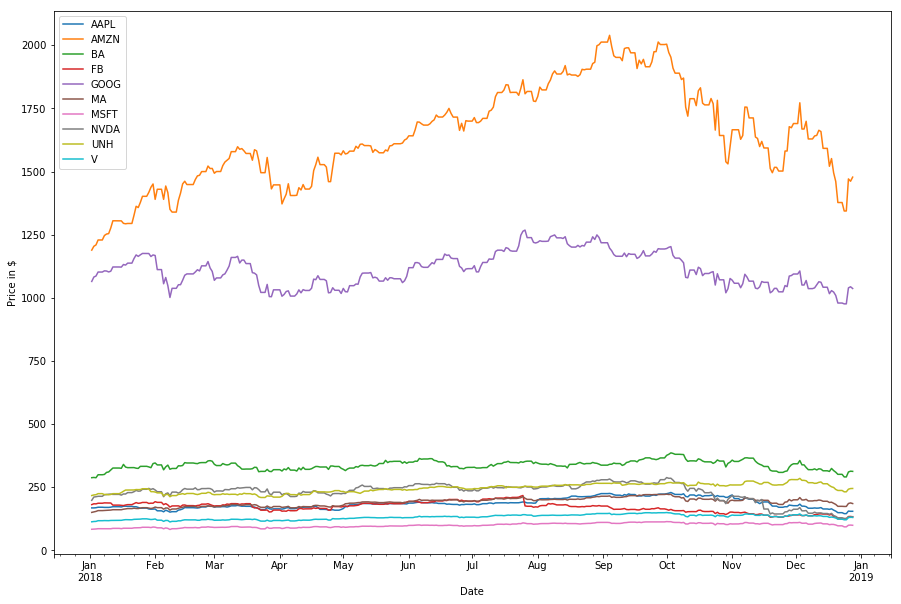

In [8]:
plt.figure(figsize=(15,10))
for stock in stocks:
    data[stock]['adj close'].plot()
plt.legend(stocks)
plt.ylabel("Price in $")

In [9]:
# I dont think this does anything
%load_ext zipline

## Set constraints 

In [10]:
# Constraints for our algorithm
initial_capital = 1000
# Time frame for our algorithm
startDate = datetime(2018,4,1,0,0,0,0,pytz.utc)
endDate = datetime(2018,12,28,0,0,0,0,pytz.utc)
# Trading calendar used for algorithm
tradingCalendar = "NYSE"

## Function Constraints 

In [84]:
def analyze(context, perf):
    fig = plt.figure()
    perf.returns.plot()

## Run Algorithm

In [189]:

# At the start of each day, this algorithm will run first
def initialize(context):
    
    # select stocks stocks for pro
    for stock in stocks:
        context.asset = symbol(stock) 
    set_commission(commission.PerTrade(cost=4.95))
             
# Returns will be a dataframe    
def handle_data(context, data):
    
        order(symbol('AAPL'),10)
        record(AAPL = data.current(symbol('AAPL'),'price'))
        
        order(symbol('AMZN'),10)
        record(AMZN = data.current(symbol("AMZN"),'price'))
        
        order(symbol('BA'),10)
        record(BA = data.current(symbol('BA'),'price'))
        
        order(symbol('GOOG'),10)
        record(FB = data.current(symbol("FB"),'price'))
        
            
        order(symbol('MA'),10)
        record(GOOG = data.current(symbol('GOOG'),'price'))
        
        order(symbol('MA'),10)
        record(MA = data.current(symbol("MA"),'price'))
        
        order(symbol('MSFT'),10)
        record(MSFT = data.current(symbol("MSFT"),'price'))
        
        order(symbol("NVDA"),10)
        record(NVDA = data.current(symbol("NVDA"),'price'))
        
        order(symbol('UNH'),10)
        record(UNH = data.current(symbol("UNH"),'price'))
        
        order(symbol("V"),10)
        record(V = data.current(symbol("V"),'price'))

In [191]:
perf = zipline.run_algorithm(start= startDate,
                             end= endDate,
                             initialize=initialize,
                             data_frequency='daily',
                             capital_base= initial_capital,
                             handle_data=handle_data,
                             data=StockPrice)
perf.head()

,AAPL,AMZN,BA,FB,GOOG,MA,MSFT,NVDA,UNH,V,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-04-02 20:00:00+00:00,166.68,1371.99,322.44,155.39,1006.47,171.60,88.52,221.05,217.20,118.39,...,0.0,0.0,0,NaN,1000.00000,0.0,0.0,1,[],0.0
2018-04-03 20:00:00+00:00,168.39,1392.05,330.82,156.11,1013.41,172.47,89.71,225.35,224.58,119.20,...,0.0,0.0,0,-11.224972,1000.00000,0.0,0.0,2,"[{'amount': 10, 'dt': 2018-04-03 20:00:00+00:0...",0.0
2018-04-04 20:00:00+00:00,171.61,1410.57,327.44,155.10,1025.14,173.69,92.33,226.24,228.79,119.81,...,0.0,0.0,0,39.223888,-38153.54225,39084.5,39084.5,3,"[{'amount': 10, 'dt': 2018-04-04 20:00:00+00:0...",0.0
2018-04-05 20:00:00+00:00,172.80,1451.75,336.40,159.34,1027.81,175.80,92.38,221.38,229.07,121.19,...,0.0,0.0,0,127.353128,-77715.88880,78986.2,78986.2,4,"[{'amount': 10, 'dt': 2018-04-05 20:00:00+00:0...",0.0
2018-04-06 20:00:00+00:00,168.38,1405.23,326.12,157.20,1007.04,169.70,90.23,214.25,223.96,117.70,...,0.0,0.0,0,-1.820404,-117829.21070,120131.4,120131.4,5,"[{'amount': 10, 'dt': 2018-04-06 20:00:00+00:0...",0.0
